<a href="https://colab.research.google.com/github/Almamun001/Mental-Health-Revised/blob/main/Hybrid_Mental_Health_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Optional: Suppress TensorFlow logs except errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [3]:
import pandas as pd

# Define the dataset path
dataset_path = "/content/drive/MyDrive/Thesis Work/Mental Health Dataset.csv"

# Load the dataset
df = pd.read_csv(dataset_path)

# Show basic info
print("✅ Dataset loaded successfully!")
print("📐 Shape:", df.shape)
print("🧾 Columns:", df.columns.tolist())
print("🔍 Sample rows:")
print(df.head())


✅ Dataset loaded successfully!
📐 Shape: (52910, 3)
🧾 Columns: ['Unnamed: 0', 'statement', 'status']
🔍 Sample rows:
   Unnamed: 0                                          statement   status
0         0.0                                         oh my gosh  Anxiety
1         1.0  trouble sleeping confused mind restless heart....  Anxiety
2         2.0  All wrong back off dear forward doubt. Stay in...  Anxiety
3         3.0  Ive shifted my focus to something else but Im ...  Anxiety
4         4.0  Im restless and restless its been a month now ...  Anxiety


In [4]:
# Remove the 'Unnamed: 0' column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)
    print("🗑️ Removed 'Unnamed: 0' column.")

# Confirm the change
print("📐 Updated shape:", df.shape)
print("🧾 Updated columns:", df.columns.tolist())


🗑️ Removed 'Unnamed: 0' column.
📐 Updated shape: (52910, 2)
🧾 Updated columns: ['statement', 'status']


In [5]:
import re

# Define a text cleaning function
def clean_text(text):
    if pd.isnull(text):
        return ""

    text = str(text)
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = text.lower()                         # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()    # Remove extra whitespace
    return text

# Apply cleaning to the 'statement' column
df['statement'] = df['statement'].apply(clean_text)

# Drop rows with fewer than 3 words
df = df[df['statement'].apply(lambda x: len(x.split()) >= 3)].reset_index(drop=True)

# Show result
print("✅ Text cleaned and short rows removed.")
print("📐 Final shape after cleaning:", df.shape)
print("🧾 Sample cleaned data:")
print(df.head())


✅ Text cleaned and short rows removed.
📐 Final shape after cleaning: (51532, 2)
🧾 Sample cleaned data:
                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping confused mind restless heart....  Anxiety
2  all wrong back off dear forward doubt. stay in...  Anxiety
3  ive shifted my focus to something else but im ...  Anxiety
4  im restless and restless its been a month now ...  Anxiety


In [6]:
# Check for null values in each column
null_counts = df.isnull().sum()

print("🔍 Null values per column:")
print(null_counts)


🔍 Null values per column:
statement    0
status       0
dtype: int64


In [7]:
class_counts = df['status'].value_counts()

print("📊 Number of samples per class:")
print(class_counts)


📊 Number of samples per class:
status
Depression              15368
Normal                  15272
Suicidal                10638
Anxiety                  3818
Bipolar                  2777
Stress                   2582
Personality disorder     1077
Name: count, dtype: int64


In [8]:
# Find duplicate rows
duplicates_mask = df.duplicated(keep=False)  # mark all duplicates, not just the first

# Filter duplicates only
duplicates_df = df[duplicates_mask]

# Count duplicates per class
duplicates_per_class = duplicates_df['status'].value_counts()

print("🔍 Number of duplicate rows per class:")
print(duplicates_per_class)


🔍 Number of duplicate rows per class:
status
Depression              578
Stress                  576
Bipolar                 552
Anxiety                 433
Personality disorder    362
Normal                  325
Suicidal                 24
Name: count, dtype: int64


In [9]:
# Optional: Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)
print(f"🗑️ Duplicates removed. New shape: {df.shape}")


🗑️ Duplicates removed. New shape: (50034, 2)


📊 Number of samples per class:
status
Depression              15066
Normal                  15062
Suicidal                10626
Anxiety                  3597
Bipolar                  2501
Stress                   2288
Personality disorder      894
Name: count, dtype: int64


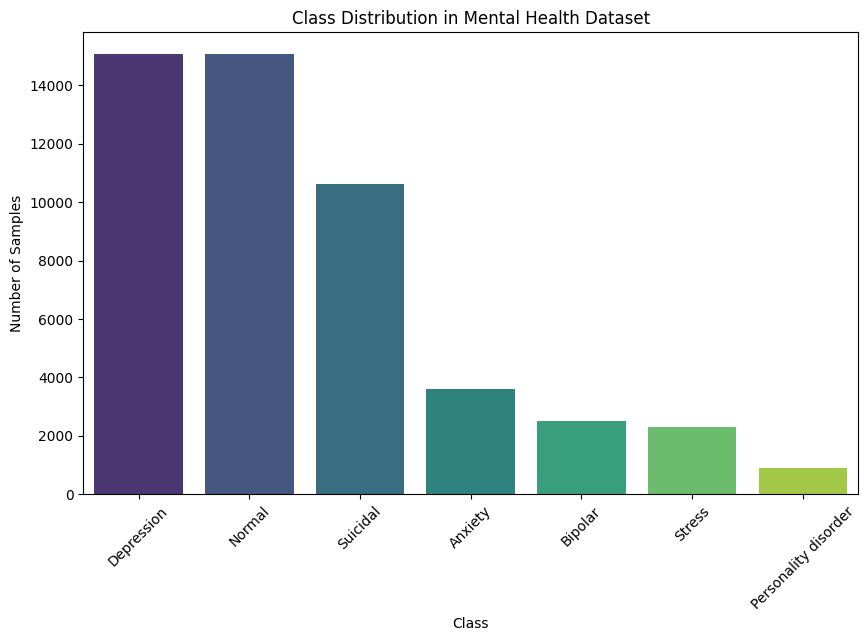

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['status'].value_counts()

print("📊 Number of samples per class:")
print(class_counts)

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='status', order=df['status'].value_counts().index, palette='viridis')
plt.title('Class Distribution in Mental Health Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()


In [11]:
from sklearn.preprocessing import LabelEncoder

# Instantiate encoder
le = LabelEncoder()

# Fit & transform the 'status' column
df['status_id'] = le.fit_transform(df['status'])

# Mapping dictionary for reference
label_to_id = dict(zip(le.classes_, le.transform(le.classes_)))
print("✅ Label encoding done. Here is the mapping:")
print(label_to_id)

# Check the new column
print(df[['status', 'status_id']].head())


✅ Label encoding done. Here is the mapping:
{'Anxiety': np.int64(0), 'Bipolar': np.int64(1), 'Depression': np.int64(2), 'Normal': np.int64(3), 'Personality disorder': np.int64(4), 'Stress': np.int64(5), 'Suicidal': np.int64(6)}
    status  status_id
0  Anxiety          0
1  Anxiety          0
2  Anxiety          0
3  Anxiety          0
4  Anxiety          0


In [12]:
from sklearn.model_selection import train_test_split

# Features (just 'statement' and later numerical features)
X = df[['statement']]  # you can add more columns later if needed
y = df['status_id']

# Stratified train-test split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"✅ Train set size: {X_train.shape[0]} samples")
print(f"✅ Test set size: {X_test.shape[0]} samples")

# Optional: check class distribution in train and test sets
print("\nTrain set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))


✅ Train set size: 40027 samples
✅ Test set size: 10007 samples

Train set class distribution:
status_id
2    0.301122
3    0.301022
6    0.212382
0    0.071901
1    0.049991
5    0.045719
4    0.017863
Name: proportion, dtype: float64

Test set class distribution:
status_id
2    0.301089
3    0.301089
6    0.212351
0    0.071850
1    0.049965
5    0.045768
4    0.017887
Name: proportion, dtype: float64


In [13]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [14]:
import random
import re
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

# Synonym replacement helpers
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ').lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(words, n):
    new_words = words.copy()
    indices = [i for i, w in enumerate(words) if get_synonyms(w)]
    random.shuffle(indices)
    num_replaced = 0
    for i in indices:
        synonyms = get_synonyms(words[i])
        if synonyms:
            new_words[i] = random.choice(synonyms)
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words

def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1 and counter < 10:
        random_word = random.choice(new_words)
        synonyms = get_synonyms(random_word)
        counter += 1
    if synonyms:
        random_synonym = random.choice(synonyms)
        insert_pos = random.randint(0, len(new_words))
        new_words.insert(insert_pos, random_synonym)

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words

def swap_word(new_words):
    if len(new_words) < 2:
        return new_words
    idx1, idx2 = random.sample(range(len(new_words)), 2)
    new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words

def random_deletion(words, p):
    if len(words) == 1:
        return words
    new_words = [w for w in words if random.uniform(0,1) > p]
    if len(new_words) == 0:
        return [random.choice(words)]
    return new_words

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=1):
    words = word_tokenize(sentence)
    num_words = len(words)

    augmented_sentences = []
    n_sr = max(1, int(alpha_sr * num_words))
    n_ri = max(1, int(alpha_ri * num_words))
    n_rs = max(1, int(alpha_rs * num_words))

    # Synonym Replacement
    for _ in range(num_aug):
        a_words = synonym_replacement(words, n_sr)
        augmented_sentences.append(' '.join(a_words))

    # Random Insertion
    for _ in range(num_aug):
        a_words = random_insertion(words, n_ri)
        augmented_sentences.append(' '.join(a_words))

    # Random Swap
    for _ in range(num_aug):
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(' '.join(a_words))

    # Random Deletion
    for _ in range(num_aug):
        a_words = random_deletion(words, p_rd)
        augmented_sentences.append(' '.join(a_words))

    return list(set(augmented_sentences))  # unique augmentations


In [15]:
from collections import Counter

def augment_minority_classes(X_train, y_train, target_count=8000):
    # X_train: pd.DataFrame with 'statement' column
    # y_train: pd.Series numeric labels

    df_train = X_train.copy()
    df_train['status_id'] = y_train.values

    class_counts = Counter(y_train)
    augmented_texts = []
    augmented_labels = []

    for cls, count in class_counts.items():
        if count < target_count:
            needed = target_count - count
            print(f"Augmenting class {cls}: current {count}, need {needed}")
            samples = df_train[df_train['status_id'] == cls]['statement'].tolist()

            i = 0
            while needed > 0:
                sent = samples[i % len(samples)]
                augmented_versions = eda(sent, num_aug=1)

                for aug_sent in augmented_versions:
                    if needed <= 0:
                        break
                    augmented_texts.append(aug_sent)
                    augmented_labels.append(cls)
                    needed -= 1

                i += 1

    # Append augmented samples to original training set
    new_X_train = pd.concat([X_train, pd.DataFrame({'statement': augmented_texts})], ignore_index=True)
    new_y_train = pd.concat([y_train, pd.Series(augmented_labels)], ignore_index=True)

    print(f"✅ Augmentation complete. New training size: {new_X_train.shape[0]}")

    return new_X_train, new_y_train

# Usage example:
X_train_aug, y_train_aug = augment_minority_classes(X_train, y_train, target_count=8000)


Augmenting class 1: current 2001, need 5999
Augmenting class 0: current 2878, need 5122
Augmenting class 5: current 1830, need 6170
Augmenting class 4: current 715, need 7285
✅ Augmentation complete. New training size: 64603


In [16]:
import pandas as pd

def downsample_majority_classes(X, y, max_count=8000, random_state=42):
    df = X.copy()
    df['status_id'] = y.values

    balanced_dfs = []
    for cls in df['status_id'].unique():
        cls_df = df[df['status_id'] == cls]
        if len(cls_df) > max_count:
            cls_df = cls_df.sample(n=max_count, random_state=random_state)
            print(f"Downsampled class {cls} from {len(df[df['status_id']==cls])} to {max_count}")
        else:
            print(f"Class {cls} has {len(cls_df)} samples, no downsampling needed")
        balanced_dfs.append(cls_df)

    balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)
    X_balanced = balanced_df.drop(columns=['status_id'])
    y_balanced = balanced_df['status_id']

    print(f"✅ Downsampling complete. New dataset size: {len(balanced_df)}")
    return X_balanced, y_balanced

# Usage example:
X_train_down, y_train_down = downsample_majority_classes(X_train_aug, y_train_aug, max_count=8000)


Downsampled class 6 from 8501 to 8000
Downsampled class 2 from 12053 to 8000
Class 1 has 8000 samples, no downsampling needed
Downsampled class 3 from 12049 to 8000
Class 0 has 8000 samples, no downsampling needed
Class 5 has 8000 samples, no downsampling needed
Class 4 has 8000 samples, no downsampling needed
✅ Downsampling complete. New dataset size: 56000


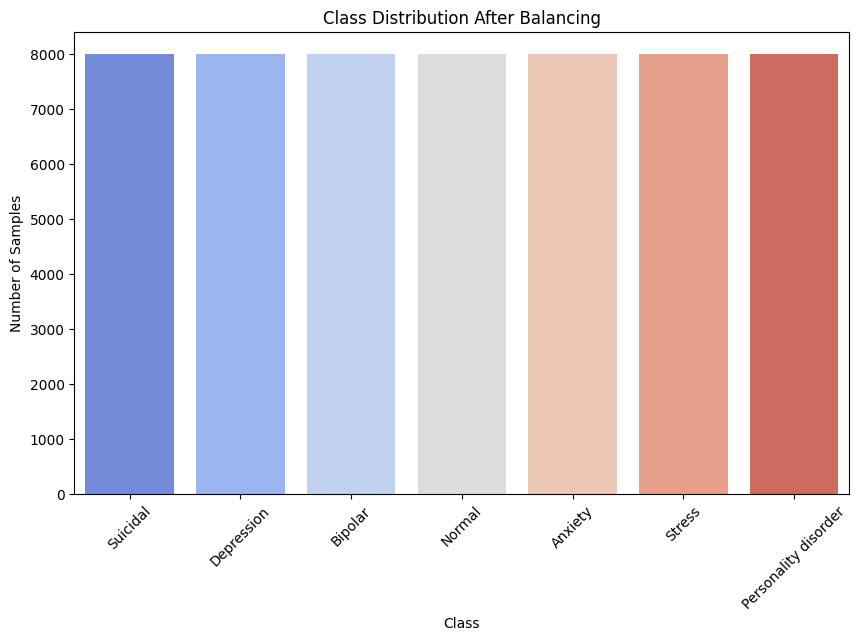

In [17]:
def plot_class_distribution(labels, id_to_label=None, title='Class Distribution After Balancing'):
    plt.figure(figsize=(10,6))
    order = labels.value_counts().index
    sns.countplot(x=labels, order=order, palette='coolwarm')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    if id_to_label:
        plt.xticks(ticks=range(len(order)), labels=[id_to_label[i] for i in order], rotation=45)
    else:
        plt.xticks(rotation=45)
    plt.show()

# Invert your label_to_id dictionary:
id_to_label = {v: k for k, v in label_to_id.items()}

# Now plot:
plot_class_distribution(y_train_down, id_to_label=id_to_label)


In [18]:
import numpy as np
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def generate_six_features(df):
    df = df.copy()

    df['statement_length'] = df['statement'].apply(len)
    df['num_words'] = df['statement'].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['statement'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
    df['stopword_ratio'] = df['statement'].apply(lambda x: np.mean([w in stop_words for w in x.split()]) if x.split() else 0)
    df['unique_word_ratio'] = df['statement'].apply(lambda x: len(set(x.split())) / len(x.split()) if x.split() else 0)
    df['sentiment_score'] = df['statement'].apply(lambda x: TextBlob(x).sentiment.polarity)

    features = ['statement_length', 'num_words', 'avg_word_length', 'stopword_ratio', 'unique_word_ratio', 'sentiment_score']
    return df[features]

# Example usage:
balanced_features = generate_six_features(X_train_down)
print("✅ Features generated for balanced data:")
print(balanced_features.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✅ Features generated for balanced data:
   statement_length  num_words  avg_word_length  stopword_ratio  \
0               771        160         3.825000        0.562500   
1               568        112         4.080357        0.526786   
2               898        186         3.833333        0.586022   
3               490         97         4.061856        0.494845   
4              1041        213         3.892019        0.544601   

   unique_word_ratio  sentiment_score  
0           0.662500         0.010354  
1           0.669643         0.081818  
2           0.575269         0.065564  
3           0.680412         0.006643  
4           0.624413         0.073133  


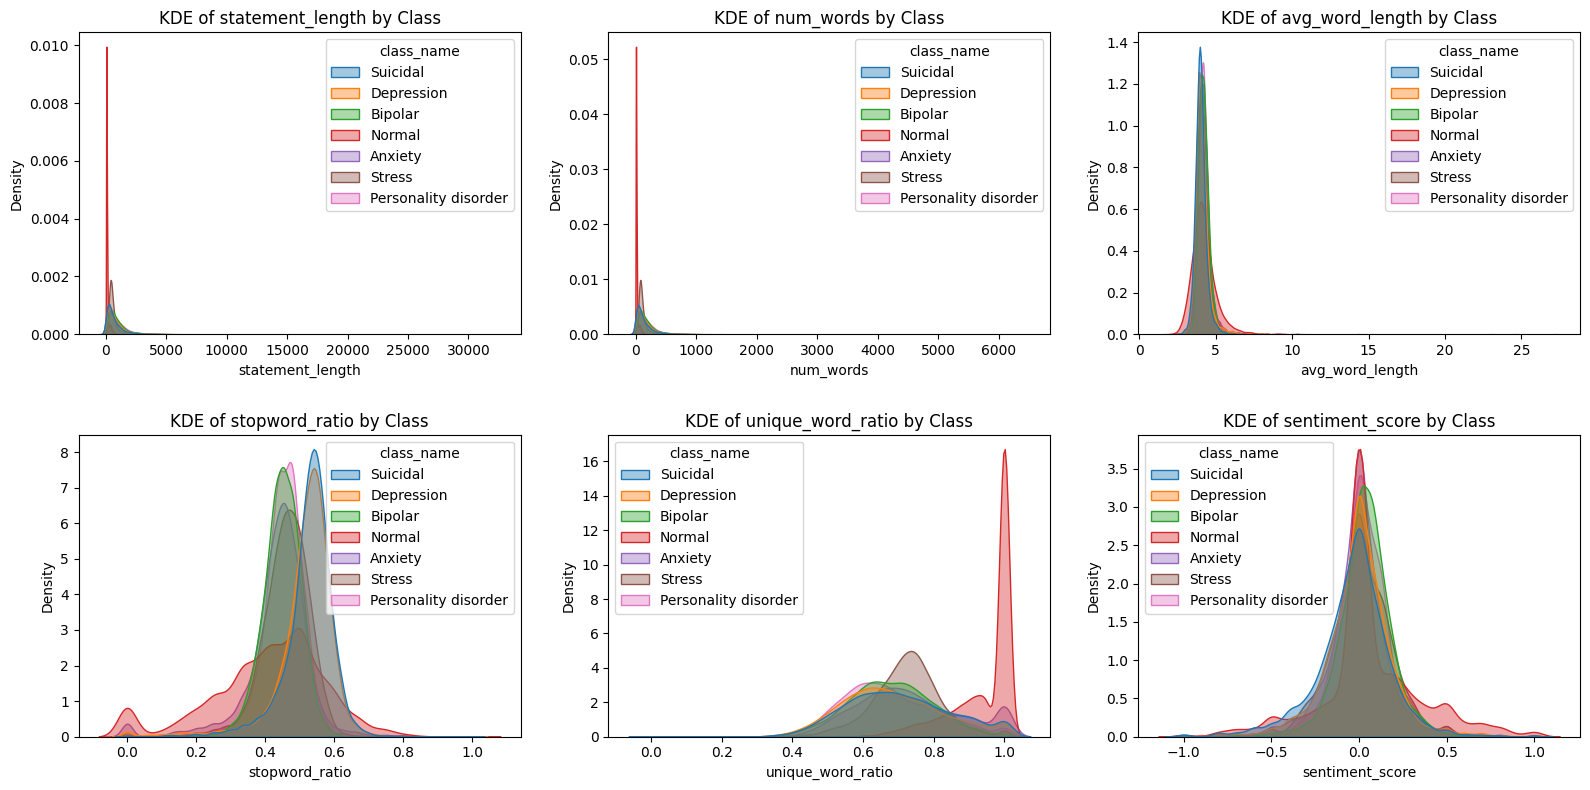

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

plot_df = balanced_features.copy()
plot_df['status_id'] = y_train_down.values

id_to_label = {
    0: 'Anxiety',
    1: 'Bipolar',
    2: 'Depression',
    3: 'Normal',
    4: 'Personality disorder',
    5: 'Stress',
    6: 'Suicidal'
}
plot_df['class_name'] = plot_df['status_id'].map(id_to_label)

features = balanced_features.columns.tolist()
num_features = len(features)

cols = 3
rows = math.ceil(num_features / cols)

plt.figure(figsize=(16, rows * 4))

for i, feature in enumerate(features, 1):
    ax = plt.subplot(rows, cols, i)
    sns.kdeplot(data=plot_df, x=feature, hue='class_name', fill=True, common_norm=False, alpha=0.4, ax=ax)
    ax.set_title(f'KDE of {feature} by Class', fontsize=12)
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')

# Add tight layout to avoid overlapping titles/xlabels
plt.tight_layout(h_pad=2.5, w_pad=2)  # Adjust padding between rows and columns
plt.show()


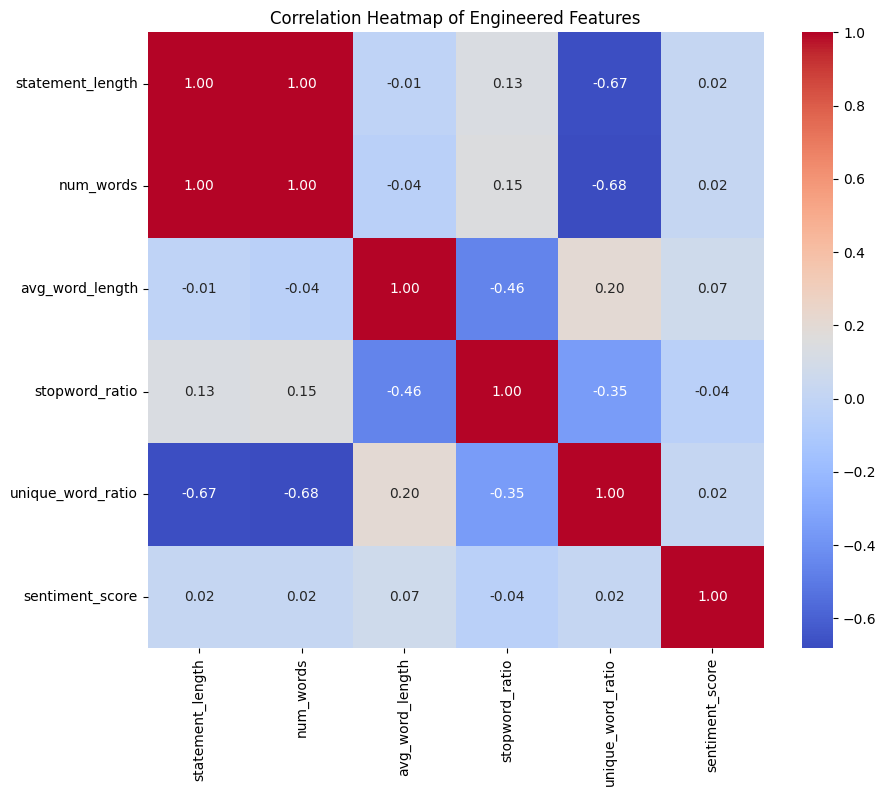

In [20]:
plt.figure(figsize=(10,8))
corr = balanced_features.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap of Engineered Features')
plt.show()


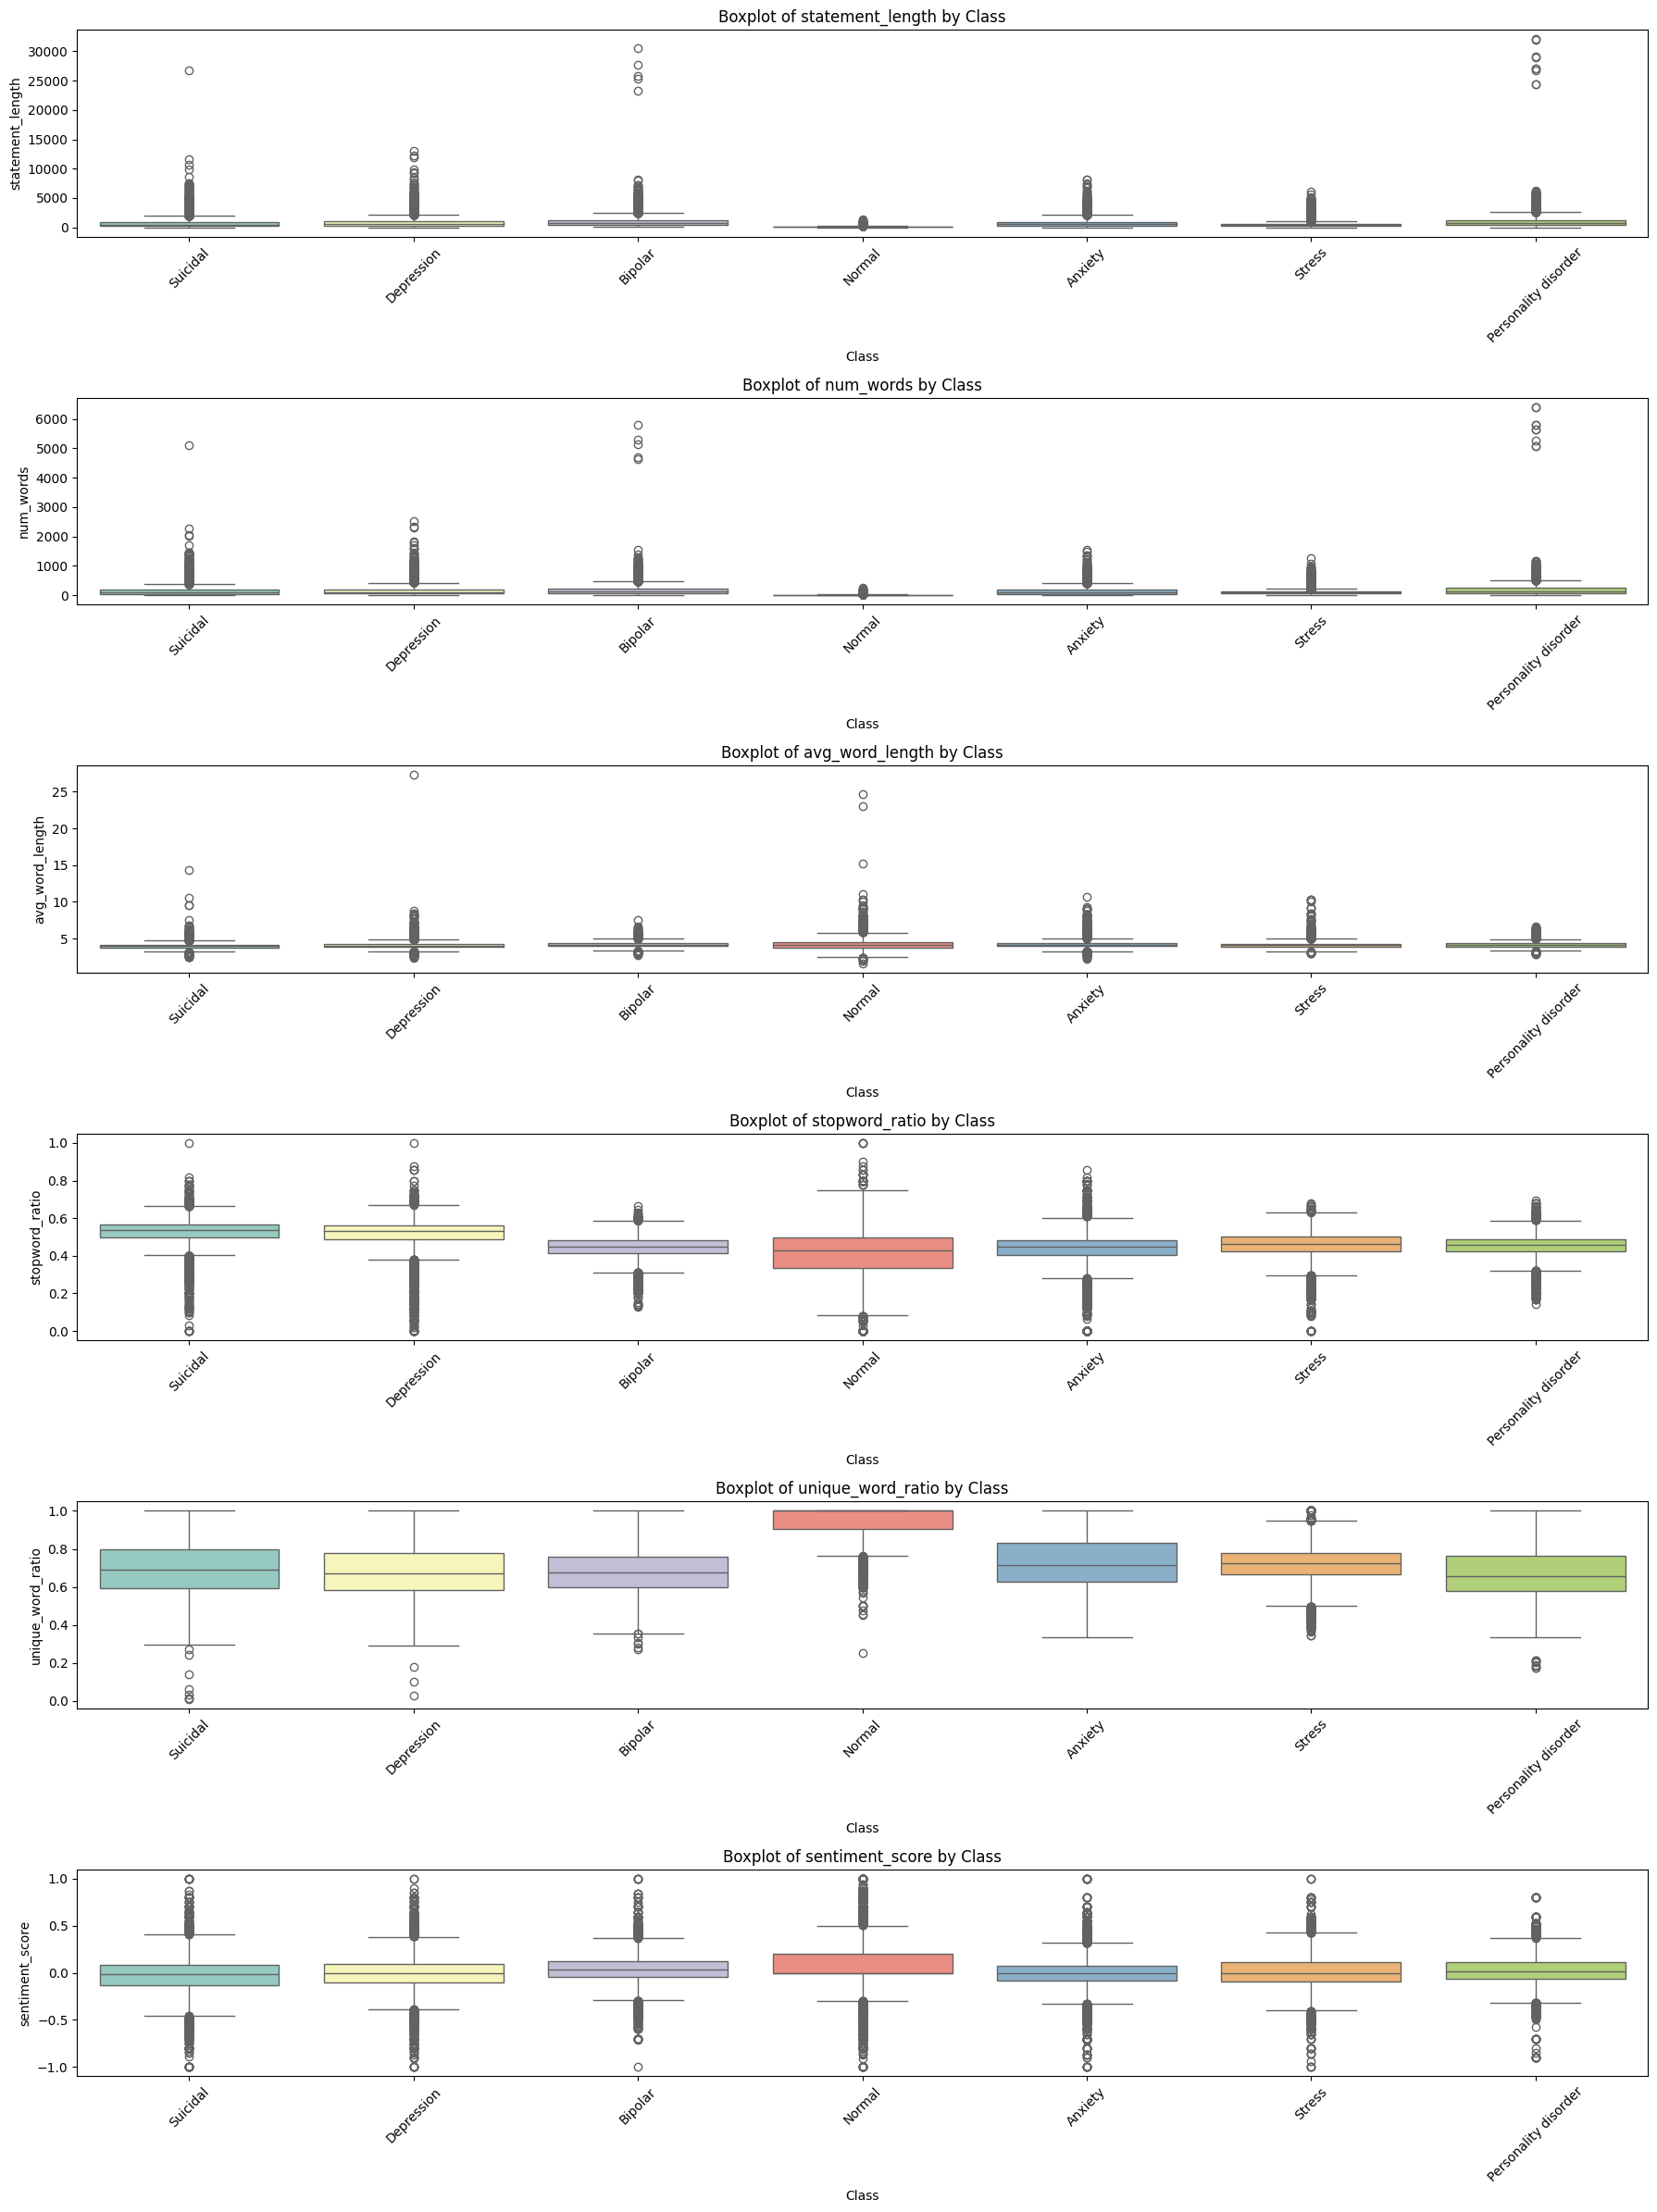

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example mapping (replace with your actual classes)
id_to_label = {
    0: 'Anxiety',
    1: 'Bipolar',
    2: 'Depression',
    3: 'Normal',
    4: 'Personality disorder',
    5: 'Stress',
    6: 'Suicidal'
}

plot_df = balanced_features.copy()
plot_df['status_id'] = y_train_down.values
plot_df['class_name'] = plot_df['status_id'].map(id_to_label)

features = balanced_features.columns.tolist()

plt.figure(figsize=(18, len(features)*4))
for i, feature in enumerate(features, 1):
    plt.subplot(len(features), 1, i)
    sns.boxplot(x='class_name', y=feature, data=plot_df, palette='Set3')
    plt.title(f'Boxplot of {feature} by Class')
    plt.xlabel('Class')
    plt.ylabel(feature)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [22]:
def handle_outliers_iqr(df):
    df = df.copy()
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with median
        median = df[col].median()
        outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        df.loc[outliers, col] = median

        print(f"{col}: {outliers.sum()} outliers replaced with median")

    return df

# ✅ Apply function here (outside)
balanced_features_cleaned = handle_outliers_iqr(balanced_features)


statement_length: 3548 outliers replaced with median
num_words: 3514 outliers replaced with median
avg_word_length: 2873 outliers replaced with median
stopword_ratio: 2808 outliers replaced with median
unique_word_ratio: 24 outliers replaced with median
sentiment_score: 4372 outliers replaced with median


In [23]:
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

def select_top_features(X, y, top_n=5, verbose=True):
    feature_names = X.columns.tolist()

    # 1️⃣ ANOVA F-score
    f_scores, _ = f_classif(X, y)
    f_score_df = pd.DataFrame({
        'feature': feature_names,
        'f_score': f_scores
    })

    # 2️⃣ Random Forest Feature Importances
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    rf_importance_df = pd.DataFrame({
        'feature': feature_names,
        'rf_importance': rf.feature_importances_
    })

    # 🔗 Combine both scores
    combined = pd.merge(f_score_df, rf_importance_df, on='feature')
    combined['rank_score'] = combined['f_score'].rank(ascending=False) + combined['rf_importance'].rank(ascending=False)
    selected_df = combined.sort_values('rank_score').head(top_n)

    if verbose:
        print("✅ Top Selected Features:\n")
        print(selected_df[['feature', 'f_score', 'rf_importance']])

    top_features = selected_df['feature'].tolist()
    return X[top_features], top_features

X_train_selected, selected_features = select_top_features(
    balanced_features_cleaned, y_train_down, top_n=5
)


✅ Top Selected Features:

             feature      f_score  rf_importance
3     stopword_ratio  2295.040468       0.197794
4  unique_word_ratio  4538.816199       0.171148
0   statement_length  2208.186968       0.183652
1          num_words  2196.334324       0.128764
2    avg_word_length   310.373805       0.158842


In [24]:
from sklearn.preprocessing import StandardScaler

# Instantiate scaler
scaler = StandardScaler()

# Fit on training data and transform
X_train_scaled = scaler.fit_transform(X_train_selected)

# Convert to NumPy array for TensorFlow model input
X_train_scaled = X_train_scaled.astype('float32')

print("✅ Selected features scaled successfully.")
print("📐 Shape after scaling:", X_train_scaled.shape)

✅ Selected features scaled successfully.
📐 Shape after scaling: (56000, 5)


In [25]:
# Generate the six features for the test set
test_features = generate_six_features(X_test)

# Select only the top features (from training feature selection)
X_test_selected = test_features[selected_features]

# Scale test features using the scaler fitted on train data
X_test_scaled = scaler.transform(X_test_selected).astype('float32')

print("✅ Test set features extracted and scaled successfully.")
print("📐 Shape:", X_test_scaled.shape)


✅ Test set features extracted and scaled successfully.
📐 Shape: (10007, 5)


In [26]:
import tensorflow as tf
from transformers import TFAutoModel
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
from sklearn.metrics import classification_report
from transformers import AutoTokenizer
import json

In [27]:
# --- Constants ---
MAX_LEN = 128
num_features = len(selected_features)  # Should be 5
num_classes = len(np.unique(y_train_down))  # Number of unique classes

# --- Tokenizer and model setup ---
MODEL_NAME = "mental/mental-bert-base-uncased"
HF_TOKEN = os.getenv("HF_TOKEN")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_auth_token=HF_TOKEN)
mental_bert = TFAutoModel.from_pretrained(MODEL_NAME, use_auth_token=HF_TOKEN, from_pt=True)


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model)

In [28]:
# --- Fine-tuning configuration ---
# Unfreeze last 3 layers of BERT
for layer in mental_bert.layers[-3:]:
    layer.trainable = True
print(f"✅ Last 3 BERT layers set as trainable")

✅ Last 3 BERT layers set as trainable


In [29]:

# --- Tokenize train and test statements ---
def tokenize_statements(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors='tf'
    )

train_tok = tokenize_statements(X_train_down['statement'])
test_tok = tokenize_statements(X_test['statement'])

X_train_ids = train_tok['input_ids'].numpy()
X_train_mask = train_tok['attention_mask'].numpy()
X_test_ids = test_tok['input_ids'].numpy()
X_test_mask = test_tok['attention_mask'].numpy()

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [30]:
class MentalBERTLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super().__init__(**kwargs)
        self.bert = bert_model

        # Store config for serialization
        self.model_name = bert_model.name
        self.config = json.loads(bert_model.config.to_json_string())

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            return_dict=True)
        return outputs.last_hidden_state

    def get_config(self):
        config = super().get_config()
        # Store necessary information to reconstruct layer
        config.update({
            "model_name": self.model_name,
            "config": self.config
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Recreate bert_model from stored configuration
        bert_model = TFAutoModel.from_pretrained(
            config["model_name"],
            config=config["config"],
            use_auth_token=HF_TOKEN
        )
        return cls(bert_model=bert_model, **config)

In [31]:
# --- Build the hybrid model ---
input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
numeric_input = Input(shape=(num_features,), dtype=tf.float32, name='numeric_input')

bert_layer = MentalBERTLayer(mental_bert, name='bert_encoder')
bert_out = bert_layer([input_ids, attention_mask])

# BiLSTM branch
bilstm_out = Bidirectional(LSTM(128, return_sequences=True))(bert_out)
bilstm_out = Bidirectional(LSTM(64))(bilstm_out)

# CNN branch
conv1 = GlobalMaxPooling1D()(Conv1D(128, 2, activation='relu', padding='same')(bert_out))
conv2 = GlobalMaxPooling1D()(Conv1D(128, 3, activation='relu', padding='same')(bert_out))
conv3 = GlobalMaxPooling1D()(Conv1D(128, 4, activation='relu', padding='same')(bert_out))
cnn_out = Concatenate()([conv1, conv2, conv3])

# Gated fusion
proj_bilstm = Dense(256, activation='tanh')(bilstm_out)
proj_cnn = Dense(256, activation='tanh')(cnn_out)
gate = Dense(256, activation='sigmoid')(Concatenate()([bilstm_out, cnn_out]))
fused_text = gate * proj_bilstm + (1 - gate) * proj_cnn
fused_text = Dense(128, activation='relu')(fused_text)

# Numeric branch
numeric_proj = Dense(32, activation='relu')(numeric_input)

# Combine text and numeric features
combined = Concatenate()([fused_text, numeric_proj])

outputs = Dense(num_classes, activation='softmax')(combined)

model = Model(inputs=[input_ids, attention_mask, numeric_input], outputs=outputs, name="hybrid_mentalbert")

# --- Optimizer with differential learning rates ---
# Higher LR for new layers, lower for fine-tuning BERT
optimizer = Adam(
    learning_rate=1e-3,  # Base LR
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "hybrid_mentalbert"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_encoder        │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│ (MentalBERTLayer)   │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 128)  │    196,736 │ bert_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 128)  │    295,040 │ bert_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 128)  │    393,344 │ bert_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 256)  │    918,528 │ bert_encoder[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     33,024 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     98,560 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256)       │          0 │ dense_2[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 256)       │          0 │ subtract[0][0], 

 Total params: 2,265,127 (8.64 MB)

 Trainable params: 2,265,127 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# --- Callbacks ---
# 1. Early stopping
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 2. Learning rate reducer
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 3. Model checkpointing
checkpoint_path = "/content/drive/MyDrive/Thesis Work/best_model.keras"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

In [33]:
# --- Training ---
history = model.fit(
    x=[X_train_ids, X_train_mask, X_train_scaled],
    y=y_train_down,
    validation_split=0.1,
    epochs=30,  # Increased epochs for fine-tuning
    batch_size=16,
    callbacks=[early_stopper, lr_reducer, model_checkpoint]
)

# Load best weights
model = tf.keras.models.load_model(
    checkpoint_path,
    custom_objects={'MentalBERTLayer': MentalBERTLayer}
)
print("✅ Loaded best model weights for evaluation")

Epoch 1/30
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6974 - loss: 0.7816
Epoch 1: val_loss improved from inf to 0.46786, saving model to /content/drive/MyDrive/Thesis Work/best_model.keras
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 598s 185ms/step - accuracy: 0.6974 - loss: 0.7815 - val_accuracy: 0.8359 - val_loss: 0.4679 - learning_rate: 0.0010
Epoch 2/30
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8655 - loss: 0.3452
Epoch 2: val_loss did not improve from 0.46786
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 620s 186ms/step - accuracy: 0.8655 - loss: 0.3452 - val_accuracy: 0.7679 - val_loss: 0.8094 - learning_rate: 0.0010
Epoch 3/30
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9007 - loss: 0.2431
Epoch 3: val_loss improved from 0.46786 to 0.45933, saving model to /content/drive/MyDrive/Thesis Work/best_model.keras
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 621s 186ms/step - accuracy: 0.9007 - loss: 0.2431 - val_accuracy: 0.8657 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 

OSError: tf_bert_model is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
# --- Predict and classification report ---
y_pred_probs = model.predict([X_test_ids, X_test_mask, X_test_scaled])
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred_classes,
    target_names=[id_to_label[i] for i in sorted(id_to_label.keys())]
))

In [ ]:
# --- Plot training history ---
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Thesis Work/training_history.png')
plt.show()